In [24]:
import pandas as pd
import sqlite3
import random
import requests

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import Image
from io import BytesIO

In [78]:
conn = sqlite3.connect('nfl_data.sqlite')

In [79]:
teams_df = pd.read_sql('SELECT * FROM teams', conn).set_index('abbreviation')

In [80]:
games_df = pd.read_sql('SELECT * FROM games', conn).set_index('gameId')

In [81]:
plays_df = pd.read_sql('SELECT * FROM plays', conn).set_index('play_uuid')

In [82]:
# (GITHUB COLAB AI) 
# prompt: load all CSV files with a name like "tracking_week_" into a tracking_df dataframe
import glob
tracking_df = pd.concat(map(pd.read_csv, glob.glob(f'data/nfl-big-data-bowl-2024/*week*.csv')))
# generate same Play-UUID for frame lookup
tracking_df['play_uuid'] = tracking_df['gameId'].astype(str) + '.' + tracking_df['playId'].astype(str)
tracking_df['club'] = tracking_df['club'].replace('LA', 'LAR').replace('WAS', 'WSH')

In [83]:
# tracking_df = pd.read_sql('SELECT * FROM tracking', conn)

In [84]:
snap_formations_df = pd.read_sql('SELECT * FROM snap_formations', conn).set_index('play_uuid')
snap_formations_df.head()

,x0,y0,s0,a0,dis0,o0,dir0,x1,y1,s1,...,yardsToGo,preSnapHomeScore,preSnapVisitorScore,offenseFormation,defendersInTheBox,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,down
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022090800.101,73.13,27.67,0.10,1.14,0.02,273.97,348.75,67.35,29.96,0.07,...,10,0,0,I_FORM,6.0,0.399819,0.600181,-0.014850,0.014850,1
2022090800.1187,71.72,29.54,0.05,0.85,0.01,272.46,55.53,69.25,24.99,0.14,...,10,0,10,SINGLEBACK,6.0,0.207237,0.792763,0.006345,-0.006345,1
2022090800.1254,59.81,23.63,0.00,0.00,0.00,272.98,143.12,42.18,36.75,0.65,...,10,0,10,PISTOL,6.0,0.227212,0.772788,0.008701,-0.008701,1
2022090800.1385,36.64,29.50,0.08,0.88,0.01,273.91,130.33,34.44,33.93,0.49,...,10,0,10,SINGLEBACK,6.0,0.235201,0.764799,0.027923,-0.027923,1
2022090800.1406,18.65,23.35,0.25,1.67,0.02,278.66,52.44,16.13,28.06,0.40,...,7,0,10,SINGLEBACK,6.0,0.263124,0.736876,0.000100,-0.000100,1


In [85]:
# Filter tracking_df for the Ball Snap Frames
ball_snap_df = tracking_df.loc[(tracking_df['event'] == 'ball_snap')] #| (tracking_df['event'] == 'autoevent_ballsnap')]
ball_snap_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [86]:
position_counts = ball_snap_df[['play_uuid', 'nflId']].groupby('play_uuid').count()
snap_ids = position_counts.loc[(position_counts['nflId'] == 22)].index
snap_ids

Index(['2022090800.101', '2022090800.1187', '2022090800.1254',
       '2022090800.1385', '2022090800.1406', '2022090800.146',
       '2022090800.1736', '2022090800.191', '2022090800.1946',
       '2022090800.2043',
       ...
       '2022110700.3787', '2022110700.403', '2022110700.443', '2022110700.493',
       '2022110700.546', '2022110700.612', '2022110700.670', '2022110700.80',
       '2022110700.929', '2022110700.950'],
      dtype='object', name='play_uuid', length=6323)

In [87]:
snap_ids = [snap_id for snap_id in snap_ids if snap_id in plays_df.index]

In [223]:
scoring_plays = tracking_df.loc[(tracking_df['event'] == 'touchdown')]['play_uuid'].unique()

In [233]:
# Create a DF of the plays with all-22 Frames available
all_22_plays_df = plays_df.loc[snap_ids]
all_22_plays_df = all_22_plays_df.loc[all_22_plays_df['possessionTeam'] == 'MIN']
all_22_plays_df

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,week,cumulativeOverall_O,cumulativeOverall_D,cumulativeOverall_P,cumulativePerFormation_O,cumulativePerFormation_D,cumulativePerFormation_P,cumulativePerBoxCt_O,cumulativePerBoxCt_D,cumulativePerBoxCt_P
play_uuid,,,,,,,,,,,,,,,,,,,,,
2022091112.1144,2022091112,1144,44853,Dalvin Cook,(7:58) D.Cook right guard to MIN 5 for 4 yards...,2,1,10,MIN,GB,...,1,0.625000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2022091112.1165,2022091112,1165,44853,Dalvin Cook,(7:14) D.Cook left guard to MIN 11 for 6 yards...,2,2,6,MIN,GB,...,1,0.555556,0.444444,0.000000,0.666667,0.333333,0.000000,0.333333,0.666667,0.000000
2022091112.1260,2022091112,1260,44853,Dalvin Cook,(4:47) D.Cook right tackle to GB 5 for 1 yard ...,2,2,3,MIN,GB,...,1,0.583333,0.416667,0.333333,0.800000,0.200000,0.500000,0.750000,0.250000,0.000000
2022091112.1458,2022091112,1458,44853,Dalvin Cook,(2:58) D.Cook left guard to MIN 35 for 9 yards...,2,1,10,MIN,GB,...,1,0.538462,0.461538,0.250000,0.666667,0.333333,0.333333,0.500000,0.500000,1.000000
2022091112.1501,2022091112,1501,44853,Dalvin Cook,(2:33) D.Cook left tackle to MIN 37 for 2 yard...,2,3,1,MIN,GB,...,1,0.500000,0.500000,0.200000,0.000000,1.000000,0.000000,0.600000,0.400000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022110607.63,2022110607,63,44853,Dalvin Cook,(14:56) D.Cook right tackle to MIN 21 for -1 y...,1,1,10,MIN,WSH,...,9,0.413043,0.679412,0.259843,0.344262,0.736434,0.246154,0.401316,0.652850,0.288136
2022110607.697,2022110607,697,38632,Kirk Cousins,(:41) K.Cousins up the middle to MIN 31 for 2 ...,1,3,1,MIN,WSH,...,9,0.407186,0.681818,0.666667,0.330709,0.746269,0.000000,0.342105,0.810811,1.000000
2022110607.737,2022110607,737,47885,Alexander Mattison,(15:00) A.Mattison left tackle to MIN 33 for 2...,2,1,10,MIN,WSH,...,9,0.408955,0.679887,0.333333,0.335938,0.740741,0.300000,0.388889,0.734177,0.125000


In [234]:
# filter for tracking frames from the all-22 df and the ball snap event.
# These will all be 22 players and the ball for each play_uuid
all_22_frames_df = ball_snap_df.loc[(ball_snap_df['play_uuid'].isin(snap_ids))]
all_22_frames_df.head()

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
5,2022100600,90,33084.0,Matt Ryan,6,2022-10-06 20:17:05.299999,2.0,IND,left,90.26,23.69,0.20,0.14,0.04,274.45,250.64,ball_snap,2022100600.90
65,2022100600,90,35459.0,Kareem Jackson,6,2022-10-06 20:17:05.299999,22.0,DEN,left,72.17,16.80,0.48,0.94,0.05,119.60,125.33,ball_snap,2022100600.90
125,2022100600,90,42030.0,K'Waun Williams,6,2022-10-06 20:17:05.299999,21.0,DEN,left,80.22,31.04,3.41,2.96,0.35,128.25,199.16,ball_snap,2022100600.90
185,2022100600,90,42393.0,Ronald Darby,6,2022-10-06 20:17:05.299999,23.0,DEN,left,76.83,36.25,0.04,0.14,0.01,73.29,206.98,ball_snap,2022100600.90
245,2022100600,90,43307.0,Ryan Kelly,6,2022-10-06 20:17:05.299999,78.0,IND,left,85.75,23.80,0.08,0.38,0.01,252.44,311.45,ball_snap,2022100600.90


In [244]:
# Select a random play from the all-22 plays
random_play =  random.randint(0, len(all_22_plays_df))
# Select the play record
play = all_22_plays_df.iloc[random_play]
random_id = play.name
play

gameId                                                                     2022100904
playId                                                                           2845
ballCarrierId                                                                   44853
ballCarrierDisplayName                                                    Dalvin Cook
playDescription                     (:25) D.Cook up the middle to CHI 46 for 7 yar...
quarter                                                                             3
down                                                                                1
yardsToGo                                                                          10
possessionTeam                                                                    MIN
defensiveTeam                                                                     CHI
yardlineSide                                                                      MIN
yardlineNumber                                        

In [245]:
play_frames = tracking_df.loc[((tracking_df['gameId'] == play['gameId']) & (tracking_df['playId'] == play['playId']))]
play_frames

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
537648,2022100904,2845,38632.0,Kirk Cousins,1,2022-10-09 15:08:16.299999,8.0,MIN,left,64.600000,23.820000,0.00,0.00,0.00,256.48,226.56,NaN,2022100904.2845
537649,2022100904,2845,38632.0,Kirk Cousins,2,2022-10-09 15:08:16.400000,8.0,MIN,left,64.600000,23.830000,0.00,0.00,0.00,256.48,225.95,NaN,2022100904.2845
537650,2022100904,2845,38632.0,Kirk Cousins,3,2022-10-09 15:08:16.500000,8.0,MIN,left,64.610000,23.830000,0.00,0.00,0.00,257.52,220.79,NaN,2022100904.2845
537651,2022100904,2845,38632.0,Kirk Cousins,4,2022-10-09 15:08:16.599999,8.0,MIN,left,64.610000,23.830000,0.01,0.14,0.00,257.52,93.92,NaN,2022100904.2845
537652,2022100904,2845,38632.0,Kirk Cousins,5,2022-10-09 15:08:16.700000,8.0,MIN,left,64.620000,23.820000,0.07,0.57,0.01,260.44,98.91,NaN,2022100904.2845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538908,2022100904,2845,NaN,football,51,2022-10-09 15:08:21.299999,NaN,football,left,56.200001,25.320000,1.84,1.26,0.21,NaN,NaN,tackle,2022100904.2845
538909,2022100904,2845,NaN,football,52,2022-10-09 15:08:21.400000,NaN,football,left,56.040001,25.420000,1.76,1.09,0.18,NaN,NaN,NaN,2022100904.2845
538910,2022100904,2845,NaN,football,53,2022-10-09 15:08:21.500000,NaN,football,left,55.900002,25.510000,1.60,1.18,0.17,NaN,NaN,NaN,2022100904.2845
538911,2022100904,2845,NaN,football,54,2022-10-09 15:08:21.599999,NaN,football,left,55.759998,25.580000,1.48,1.11,0.16,NaN,NaN,NaN,2022100904.2845


In [246]:
len(tracking_df['nflId'].unique())

1684

In [247]:
# Select the tracking player positions from ball-snap for this play
play_frame = ball_snap_df.loc[(ball_snap_df['play_uuid'] == play.name)]
play_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
537653,2022100904,2845,38632.0,Kirk Cousins,6,2022-10-09 15:08:16.799999,8.0,MIN,left,64.630000,23.82,0.18,0.95,0.02,262.30,102.80,ball_snap,2022100904.2845
537708,2022100904,2845,40488.0,Adam Thielen,6,2022-10-09 15:08:16.799999,19.0,MIN,left,66.190000,26.84,6.56,1.66,0.65,187.67,177.08,ball_snap,2022100904.2845
537763,2022100904,2845,42443.0,Angelo Blackson,6,2022-10-09 15:08:16.799999,90.0,CHI,left,62.400000,26.20,0.11,0.73,0.01,129.27,97.86,ball_snap,2022100904.2845
537818,2022100904,2845,44853.0,Dalvin Cook,6,2022-10-09 15:08:16.799999,4.0,MIN,left,71.110000,23.38,0.00,0.00,0.02,297.27,304.30,ball_snap,2022100904.2845
537873,2022100904,2845,44925.0,Eddie Jackson,6,2022-10-09 15:08:16.799999,4.0,CHI,left,50.660000,25.57,1.32,0.78,0.13,86.41,264.22,ball_snap,2022100904.2845
537928,2022100904,2845,45094.0,Johnny Mundt,6,2022-10-09 15:08:16.799999,86.0,MIN,left,64.350000,28.17,0.02,0.45,0.01,243.06,219.03,ball_snap,2022100904.2845
537983,2022100904,2845,45345.0,Nicholas Morrow,6,2022-10-09 15:08:16.799999,53.0,CHI,left,58.590000,24.71,1.31,0.65,0.13,88.69,169.78,ball_snap,2022100904.2845
538038,2022100904,2845,46077.0,Roquan Smith,6,2022-10-09 15:08:16.799999,58.0,CHI,left,58.910000,21.79,0.67,1.99,0.07,99.30,179.59,ball_snap,2022100904.2845
538093,2022100904,2845,46131.0,Brian O'Neill,6,2022-10-09 15:08:16.799999,75.0,MIN,left,64.340000,26.73,0.41,1.43,0.04,267.28,221.49,ball_snap,2022100904.2845
538148,2022100904,2845,47801.0,Garrett Bradbury,6,2022-10-09 15:08:16.799999,56.0,MIN,left,63.490000,23.80,0.10,0.32,0.01,269.56,222.51,ball_snap,2022100904.2845


In [248]:
last_frame_id = tracking_df.loc[(tracking_df['play_uuid'] == play.name)]['frameId'].max()
last_frame = tracking_df.loc[((tracking_df['play_uuid'] == play.name) & (tracking_df['frameId'] == last_frame_id))]
last_frame

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event,play_uuid
537702,2022100904,2845,38632.0,Kirk Cousins,55,2022-10-09 15:08:21.700000,8.0,MIN,left,72.400000,23.330000,1.10,0.21,0.11,278.02,277.34,NaN,2022100904.2845
537757,2022100904,2845,40488.0,Adam Thielen,55,2022-10-09 15:08:21.700000,19.0,MIN,left,53.760000,16.630000,2.60,1.69,0.27,299.11,337.04,NaN,2022100904.2845
537812,2022100904,2845,42443.0,Angelo Blackson,55,2022-10-09 15:08:21.700000,90.0,CHI,left,61.200000,25.680000,1.98,0.81,0.20,286.91,268.79,NaN,2022100904.2845
537867,2022100904,2845,44853.0,Dalvin Cook,55,2022-10-09 15:08:21.700000,4.0,MIN,left,55.280000,25.860000,1.70,1.53,0.17,192.30,299.39,NaN,2022100904.2845
537922,2022100904,2845,44925.0,Eddie Jackson,55,2022-10-09 15:08:21.700000,4.0,CHI,left,57.340000,24.880000,0.63,0.98,0.06,6.60,287.12,NaN,2022100904.2845
537977,2022100904,2845,45094.0,Johnny Mundt,55,2022-10-09 15:08:21.700000,86.0,MIN,left,59.060000,25.700000,3.15,0.65,0.32,271.74,287.20,NaN,2022100904.2845
538032,2022100904,2845,45345.0,Nicholas Morrow,55,2022-10-09 15:08:21.700000,53.0,CHI,left,60.620000,23.230000,0.61,0.94,0.06,270.42,287.52,NaN,2022100904.2845
538087,2022100904,2845,46077.0,Roquan Smith,55,2022-10-09 15:08:21.700000,58.0,CHI,left,51.370000,21.520000,2.89,2.45,0.29,354.33,304.57,NaN,2022100904.2845
538142,2022100904,2845,46131.0,Brian O'Neill,55,2022-10-09 15:08:21.700000,75.0,MIN,left,62.520000,27.210000,0.97,0.54,0.10,247.23,266.77,NaN,2022100904.2845
538197,2022100904,2845,47801.0,Garrett Bradbury,55,2022-10-09 15:08:21.700000,56.0,MIN,left,58.720000,23.920000,1.43,1.12,0.15,258.22,306.14,NaN,2022100904.2845


In [249]:
# Select the game for this play
game = games_df.loc[play['gameId']]
game

season                     2022
week                          5
gameDate             10/09/2022
gameTimeEastern        13:00:00
homeTeamAbbr                MIN
visitorTeamAbbr             CHI
homeFinalScore               29
visitorFinalScore            22
Name: 2022100904, dtype: object

In [250]:
# Load the Home team logo from the ESPN API 
response = requests.get(teams_df.loc[game['homeTeamAbbr']]['logo'])
home_img = Image.open(BytesIO(response.content))
# Load the away team logo from the ESPN API
response = requests.get(teams_df.loc[game['visitorTeamAbbr']]['logo'])
away_img = Image.open(BytesIO(response.content))

In [251]:
# Initialize team colors from the ESPN API
teams = play_frame['club'].unique()
colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['color']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['color']), 
          'football': 'brown'}
alt_colors = {teams[0]: mcolors.to_rgba('#' + teams_df.loc[teams[0]]['alternateColor']), 
          teams[1]: mcolors.to_rgba('#' + teams_df.loc[teams[1]]['alternateColor']), 
          'football': 'yellow'}

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_44083/4208403530.py:60: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']


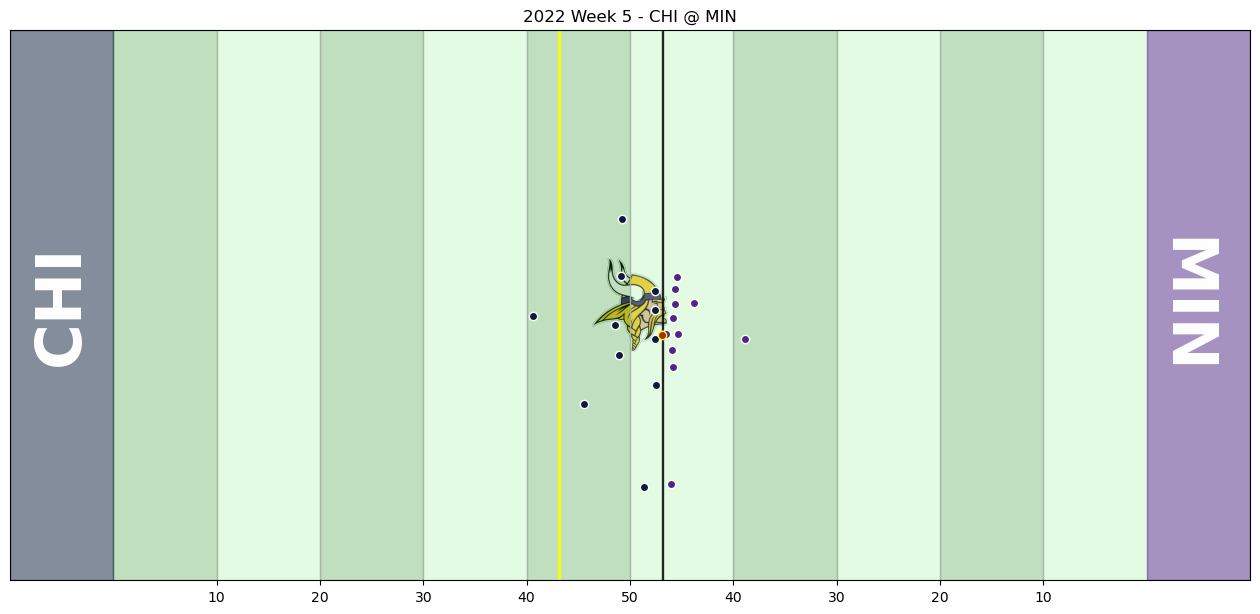

/var/folders/m8/xlwp526d3sxf6fyr2v802l_80000gn/T/ipykernel_44083/4208403530.py:124: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']


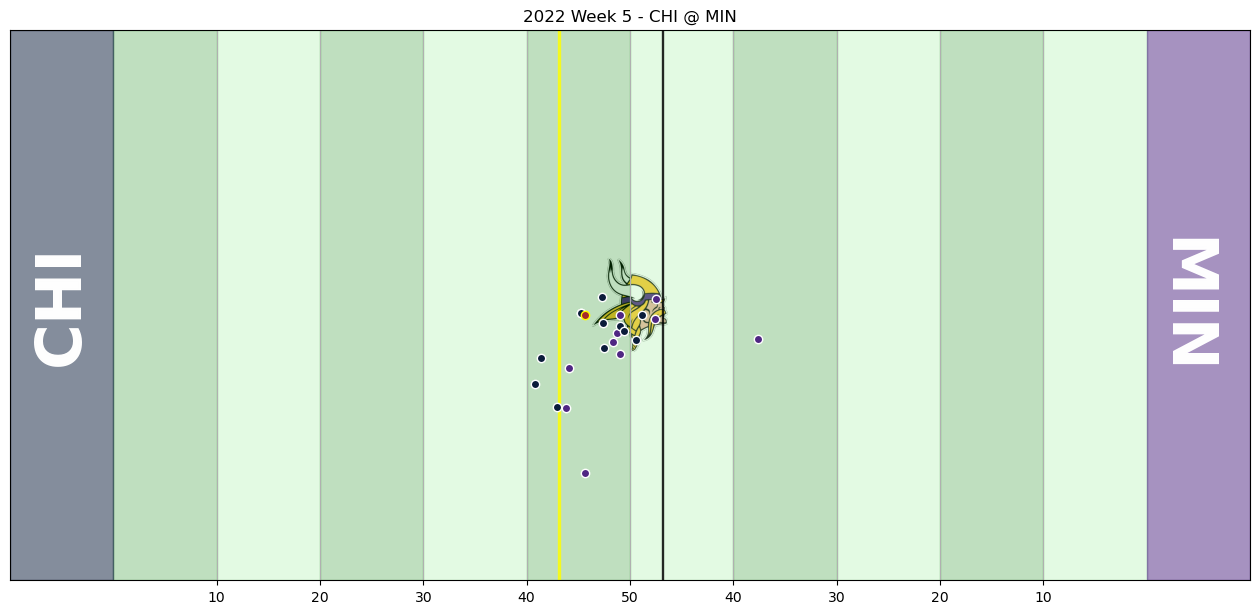

In [252]:
# Build Field and Play formation plot with Matplotlib

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(play_frame[play_frame['club'] == team]['x'], play_frame[play_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

# Init figure and title
plt.figure(figsize=(16, 8))
plt.title(f"{game['season']} Week {game['week']} - {game['visitorTeamAbbr']} @ {game['homeTeamAbbr']}")

# Set x and y scales
plt.xlim(0, 120)  # Adjust the limits according to your data
plt.ylim(0, 53.3)  # Adjust the limits according to your data

# Create vertical bands of green and lightgreen for the field
for i in range(10, 101, 20):    
    plt.axvspan(i, i+10, color='green', alpha=0.25)
    plt.axvspan(i+10, i+20, color='lightgreen', alpha=0.25)

# Hide y-axis labels
plt.yticks(ticks=[], labels=[])

# Yard line labels
plt.xticks(ticks=[20,30,40,50,60,70,80,90,100],
           labels=['10','20','30','40','50','40','30','20','10'])

# Determine play orientation - which team is to the right
x_max = max(play_frame['x'])
max_team = play_frame.loc[(play_frame['x'] == x_max)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(max_team, xy=[113.5, 26.65], xytext=[113.5, 26.65], fontsize=45, 
            fontweight='bold',color='white', rotation=270,ha='center', va='center')
plt.axvspan(110, 120, color=colors[max_team], alpha=0.5)

# Determine play orientation - team to the left
x_min = min(play_frame['x'])
min_team = play_frame.loc[(play_frame['x'] == x_min)].iloc[0]['club']

# Create end zone with team color and abbreviation
plt.annotate(min_team, xy=[5,26.65], xytext=[5,26.65], fontsize=45, fontweight='bold',
             color='white', rotation=90,ha='center', va='center')
plt.axvspan(0, 10, color=colors[min_team], alpha=0.5)

# Plot home team logo at 50 yard line
plt.imshow(home_img, extent=[55,65,21.65,31.65])

# Determine x Position for First Down marker
if play_frame.iloc[2]['playDirection'] == 'right':
    first_down = play_frame.iloc[22]['x'] + play['yardsToGo']
else:
    first_down = play_frame.iloc[22]['x'] - play['yardsToGo']

# Plot first down and line of scrimmage markers
plt.axvspan(first_down-0.125, first_down+0.125, color='yellow', alpha=0.75)
plt.axvspan(play_frame.iloc[22]['x']-0.05, play_frame.iloc[22]['x']+0.05, color='black', alpha=0.75)

# Scatter plot for player and football positions
for team, color in colors.items():
    if team == 'football':
        edge = 'yellow'
    else:
        edge = 'white'
    plt.scatter(last_frame[last_frame['club'] == team]['x'], last_frame[last_frame['club'] == team]['y']
                ,c=color, label=team, alpha=1, edgecolor=edge)

# Show plot
plt.grid(True, axis='x')
plt.show()

